In [3]:
!pip install peft

The New "LoRA-Powered" Model Code
Replace your Model Definition (Block 5) with this code. I have integrated LoRA specifically for CLIP.

In [4]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Text Preprocessing Imports ---
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Download stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# --- 2. Define Preprocessing Function ---
def preprocess_text(text):
    text = str(text) 
    # 1. Removal of HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. To Lower Case
    text = text.lower()
    
    # 3. Removal of URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 4. Removal of Twitter Handles (@user)
    text = re.sub(r'@\w+', '', text)
    
    # 5. Removal of Hashtag symbol (keeping text)
    text = re.sub(r'#', '', text) 
    
    # 6. Removal of Placeholders
    text = re.sub(r'\[.*?\]', '', text)

    # 7. Removal of Punctuation & Non-letter Characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 8. Removal of Stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # 9. Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✅ Setup & Preprocessing Function Ready!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nabil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🚀 Device: cuda
✅ Setup & Preprocessing Function Ready!


In [5]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
# --- 5. Define the Fine-Tuning Model (Updated for Higher Accuracy) ---
class MultimodalDisasterClassifier(nn.Module):
    def __init__(self, model_id, num_classes=2):
        super(MultimodalDisasterClassifier, self).__init__()
        
        print(f"Loading {model_id} with SafeTensors...")
        self.clip = CLIPModel.from_pretrained(model_id, use_safetensors=True)
        
        # Increased capacity in the head (Standard 512 -> 256 -> 2)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   # Added BatchNorm for stability
            nn.ReLU(),
            nn.Dropout(0.3),       # Increased Dropout to 0.3
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        text_out = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        img_out = self.clip.get_image_features(pixel_values=pixel_values)
        
        # Normalize
        text_out = text_out / text_out.norm(dim=-1, keepdim=True)
        img_out = img_out / img_out.norm(dim=-1, keepdim=True)
        
        combined = torch.cat((img_out, text_out), dim=1)
        logits = self.classifier(combined.float())
        return logits

# Initialize
model_id = "openai/clip-vit-base-patch32"
model = MultimodalDisasterClassifier(model_id).to(device)

# --- ADVANCED UNFREEZING LOGIC ---
# 1. Freeze everything
for param in model.clip.parameters():
    param.requires_grad = False

# 2. Unfreeze Classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# 3. Unfreeze LAST 2 LAYERS of Vision & Text Encoders (Deeper adaptation)
# Note: 'layers' index allows slicing. [-2:] means the last 2 blocks.
print("🔓 Unfreezing last 2 visual layers...")
for layer in model.clip.vision_model.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

print("🔓 Unfreezing last 2 text layers...")
for layer in model.clip.text_model.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

print("✅ Model initialized with Deeper Fine-Tuning!")

Loading openai/clip-vit-base-patch32 with SafeTensors...
🔓 Unfreezing last 2 visual layers...
🔓 Unfreezing last 2 text layers...
✅ Model initialized with Deeper Fine-Tuning!


In [6]:
from peft import LoraConfig, get_peft_model


# --- 5. Define the LoRA-Enhanced Model ---
class MultimodalLoRAClassifier(nn.Module):
    def __init__(self, model_id, num_classes=2):
        super(MultimodalLoRAClassifier, self).__init__()
        
        print(f"Loading {model_id} with SafeTensors...")
        # 1. Load Base Model
        self.clip = CLIPModel.from_pretrained(model_id, use_safetensors=True)
        
        # 2. Apply LoRA Configuration
        # We target the "Query" and "Value" matrices in the Attention blocks
        # This is where the model learns relationships between words and image patches.
        config = LoraConfig(
            r=32,                   # Rank (Higher = smarter but heavier. 16-64 is standard)
            lora_alpha=64,          # Scaling factor (usually 2x Rank)
            target_modules=["q_proj", "v_proj"], # Apply LoRA to attention layers
            lora_dropout=0.1,       # Helps prevent overfitting
            bias="none"
        )
        
        # Wrap the CLIP model with LoRA
        self.clip = get_peft_model(self.clip, config)
        print("✅ LoRA Adapters Injected successfully!")
        self.clip.print_trainable_parameters() # Show supervisor how efficient it is
        
        # 3. The Classifier Head (Remains Full Trainable)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),    # Added Batch Norm for 90% push
            nn.ReLU(),
            nn.Dropout(0.4),        # High Dropout to force generalization
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # 1. Extract Features (LoRA active here)
        text_out = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        img_out = self.clip.get_image_features(pixel_values=pixel_values)
        
        # 2. Normalize
        text_out = text_out / text_out.norm(dim=-1, keepdim=True)
        img_out = img_out / img_out.norm(dim=-1, keepdim=True)
        
        # 3. Fusion
        combined = torch.cat((img_out, text_out), dim=1)
        
        # 4. Classification
        return self.classifier(combined.float())

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLoRAClassifier("openai/clip-vit-base-patch32").to(device)

print("🚀 Model is ready for LoRA Fine-Tuning!")

Loading openai/clip-vit-base-patch32 with SafeTensors...
✅ LoRA Adapters Injected successfully!
trainable params: 1,966,080 || all params: 153,243,393 || trainable%: 1.2830
🚀 Model is ready for LoRA Fine-Tuning!


The Updated Training Loop
Because LoRA handles the freezing internally, the training loop is actually simpler. You don't need manual unfreezing loops anymore.

In [7]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Text Preprocessing Imports ---
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Download stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# --- 2. Define Preprocessing Function ---
def preprocess_text(text):
    text = str(text) 
    # 1. Removal of HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. To Lower Case
    text = text.lower()
    
    # 3. Removal of URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 4. Removal of Twitter Handles (@user)
    text = re.sub(r'@\w+', '', text)
    
    # 5. Removal of Hashtag symbol (keeping text)
    text = re.sub(r'#', '', text) 
    
    # 6. Removal of Placeholders
    text = re.sub(r'\[.*?\]', '', text)

    # 7. Removal of Punctuation & Non-letter Characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 8. Removal of Stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # 9. Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✅ Setup & Preprocessing Function Ready!")

🚀 Device: cuda
✅ Setup & Preprocessing Function Ready!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nabil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# --- 3. Define Custom Dataset Class ---
class CrisisDataset(Dataset):
    def __init__(self, df, processor, data_path="."):
        self.df = df
        self.processor = processor
        self.data_path = data_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['tweet_text']
        label = row['label']
        img_path = os.path.join(self.data_path, row['image'])
        
        try:
            # Load and convert image
            image = Image.open(img_path).convert("RGB")
            
            # CLIP Processor handles Image Resizing/Norm + Text Tokenization
            encoding = self.processor(
                text=text, 
                images=image, 
                return_tensors="pt", 
                padding="max_length", 
                truncation=True, 
                max_length=77
            )
            
            # Remove batch dimension added by processor
            return {
                'pixel_values': encoding['pixel_values'].squeeze(0),
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'label': torch.tensor(label, dtype=torch.long)
            }
        except Exception as e:
            # If an image fails, return the next one (simple error handling)
            return self.__getitem__((idx + 1) % len(self.df))

print("✅ Dataset Class Defined!")

✅ Dataset Class Defined!


In [9]:
# --- 4. Load & Clean Data ---
# Define paths (Adjust these to match your folder structure)
train_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv")
test_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv")

# Load DataFrames
train_df = pd.read_csv(train_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

# Function to encode labels
def encode_label(row):
    if row['label_image'] == 'informative': return 1
    elif row['label_image'] == 'not_informative': return 0
    return None

# Apply Label Encoding
train_df['label'] = train_df.apply(encode_label, axis=1)
test_df['label'] = test_df.apply(encode_label, axis=1)

# Drop NaNs
train_df = train_df.dropna(subset=['label'])
test_df = test_df.dropna(subset=['label'])
train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

# --- APPLY PREPROCESSING HERE ---
print("⏳ Applying Text Preprocessing (Steps 1-9)...")
tqdm.pandas() # Progress bar
train_df['tweet_text'] = train_df['tweet_text'].progress_apply(preprocess_text)
test_df['tweet_text'] = test_df['tweet_text'].progress_apply(preprocess_text)

# Initialize Processor
model_id = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_id)

# Create Datasets & Loaders
batch_size = 32 # Keep small for GPU memory
train_dataset = CrisisDataset(train_df, processor)
test_dataset = CrisisDataset(test_df, processor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Data Ready! Train: {len(train_df)}, Test: {len(test_df)}")

⏳ Applying Text Preprocessing (Steps 1-9)...


100%|██████████| 2237/2237 [00:00<00:00, 13318.07it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Data Ready! Train: 13608, Test: 2237


In [10]:
# --- 5. Define the Fine-Tuning Model (Updated for Higher Accuracy) ---
class MultimodalDisasterClassifier(nn.Module):
    def __init__(self, model_id, num_classes=2):
        super(MultimodalDisasterClassifier, self).__init__()
        
        print(f"Loading {model_id} with SafeTensors...")
        self.clip = CLIPModel.from_pretrained(model_id, use_safetensors=True)
        
        # Increased capacity in the head (Standard 512 -> 256 -> 2)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   # Added BatchNorm for stability
            nn.ReLU(),
            nn.Dropout(0.3),       # Increased Dropout to 0.3
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        text_out = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        img_out = self.clip.get_image_features(pixel_values=pixel_values)
        
        # Normalize
        text_out = text_out / text_out.norm(dim=-1, keepdim=True)
        img_out = img_out / img_out.norm(dim=-1, keepdim=True)
        
        combined = torch.cat((img_out, text_out), dim=1)
        logits = self.classifier(combined.float())
        return logits

# Initialize
model_id = "openai/clip-vit-base-patch32"
model = MultimodalDisasterClassifier(model_id).to(device)

# --- ADVANCED UNFREEZING LOGIC ---
# 1. Freeze everything
for param in model.clip.parameters():
    param.requires_grad = False

# 2. Unfreeze Classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# 3. Unfreeze LAST 2 LAYERS of Vision & Text Encoders (Deeper adaptation)
# Note: 'layers' index allows slicing. [-2:] means the last 2 blocks.
print("🔓 Unfreezing last 2 visual layers...")
for layer in model.clip.vision_model.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

print("🔓 Unfreezing last 2 text layers...")
for layer in model.clip.text_model.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

print("✅ Model initialized with Deeper Fine-Tuning!")

Loading openai/clip-vit-base-patch32 with SafeTensors...
🔓 Unfreezing last 2 visual layers...
🔓 Unfreezing last 2 text layers...
✅ Model initialized with Deeper Fine-Tuning!


🚀 Starting Advanced Training for 10 Epochs...


Epoch 1/10:  13%|█▎        | 57/426 [01:16<08:40,  1.41s/it, loss=0.675]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10: 100%|██████████| 426/426 [10:52<00:00,  1.53s/it, loss=0.334]


📉 Train Loss: 0.5067 | 📈 Val Acc: 0.8900
💾 New Best Model Saved!


Epoch 2/10: 100%|██████████| 426/426 [05:41<00:00,  1.25it/s, loss=0.233]


📉 Train Loss: 0.3856 | 📈 Val Acc: 0.8887


Epoch 3/10: 100%|██████████| 426/426 [05:39<00:00,  1.25it/s, loss=0.404]


📉 Train Loss: 0.3623 | 📈 Val Acc: 0.8865


Epoch 4/10: 100%|██████████| 426/426 [05:38<00:00,  1.26it/s, loss=0.219]


📉 Train Loss: 0.3404 | 📈 Val Acc: 0.8873


Epoch 5/10: 100%|██████████| 426/426 [08:24<00:00,  1.18s/it, loss=0.346]


📉 Train Loss: 0.3213 | 📈 Val Acc: 0.8878


Epoch 6/10: 100%|██████████| 426/426 [05:56<00:00,  1.19it/s, loss=0.361]


📉 Train Loss: 0.3086 | 📈 Val Acc: 0.8878


Epoch 7/10: 100%|██████████| 426/426 [09:38<00:00,  1.36s/it, loss=0.326]


📉 Train Loss: 0.2950 | 📈 Val Acc: 0.8887


Epoch 8/10: 100%|██████████| 426/426 [11:51<00:00,  1.67s/it, loss=0.367]


📉 Train Loss: 0.2857 | 📈 Val Acc: 0.8869


Epoch 9/10: 100%|██████████| 426/426 [15:49<00:00,  2.23s/it, loss=0.214]


📉 Train Loss: 0.2768 | 📈 Val Acc: 0.8865


Epoch 10/10: 100%|██████████| 426/426 [06:52<00:00,  1.03it/s, loss=0.371]


📉 Train Loss: 0.2721 | 📈 Val Acc: 0.8865

🏆 Loading Best Model (Acc: 0.8900)...


C:\Users\nabil\AppData\Local\Temp\ipykernel_18296\3117315705.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vlm_model.pth"))


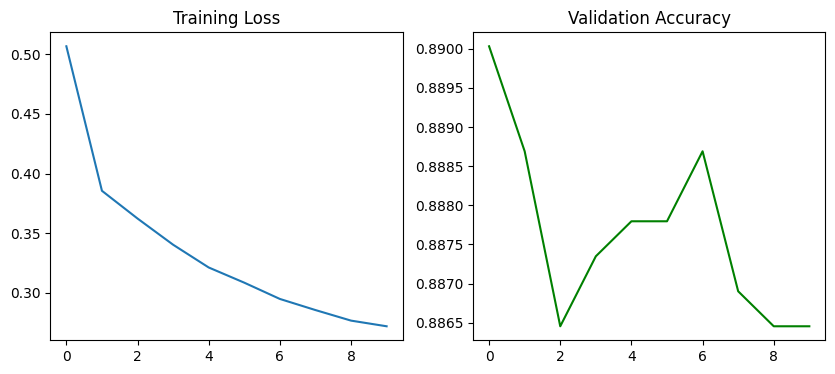

In [11]:
from transformers import get_linear_schedule_with_warmup

# --- 6. Advanced Training Loop ---

# A. Hyperparameters
EPOCHS = 10  # Increased epochs (Early stopping will catch the best one)
BATCH_SIZE = 32
learning_rate = 2e-5 # Slightly higher starting rate for Scheduler to manage

# B. Optimizer & Scheduler
optimizer = optim.AdamW([
    {'params': model.clip.parameters(), 'lr': 1e-6}, # Backbone stays slow
    {'params': model.classifier.parameters(), 'lr': 1e-4} # Head learns fast
], weight_decay=0.01) # Increased weight decay

# Total steps = (batches per epoch) * epochs
total_steps = len(train_loader) * EPOCHS

# Linear Scheduler with Warmup (Standard for Transformers)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.1 * total_steps), # Warmup for first 10%
    num_training_steps=total_steps
)

# Label Smoothing Loss (Helps with noisy labels)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# C. Training with Validation Tracking
print(f"🚀 Starting Advanced Training for {EPOCHS} Epochs...")

best_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, pixel_values)
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient Clipping (Prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step() # Update learning rate
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- VALIDATION (Check performance after every epoch) ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask, pixel_values)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    print(f"📉 Train Loss: {avg_train_loss:.4f} | 📈 Val Acc: {val_acc:.4f}")
    
    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vlm_model.pth")
        print("💾 New Best Model Saved!")

# D. Load the Best Model for Final Evaluation
print(f"\n🏆 Loading Best Model (Acc: {best_acc:.4f})...")
model.load_state_dict(torch.load("best_vlm_model.pth"))

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Accuracy', color='green')
plt.title('Validation Accuracy')
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from peft import LoraConfig, get_peft_model
from tqdm import tqdm

# --- A. RE-INITIALIZE YOUR BASE MODEL (CRITICAL) ---
# RESTART YOUR KERNEL BEFORE RUNNING THIS.
# Replace "your-model-id-here" with your actual model path (e.g., "openai/clip-vit-base-patch32")
MODEL_ID = "openai/clip-vit-base-patch32" # <-- UPDATE THIS ACCORDING TO YOUR THESIS CODE

model = MultimodalDisasterClassifier(model_id=MODEL_ID, num_classes=2) 
model.to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

# --- B. DEFINE HELPERS ---
class MockConfig:
    def __init__(self):
        self.tie_word_embeddings = False
        self.use_return_dict = False
    def get(self, key, default=None):
        return getattr(self, key, default)

class EarlyStopper:
    def __init__(self, patience=4):
        self.patience, self.counter, self.best_acc, self.early_stop = patience, 0, 0.0, False
    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc, self.counter = val_acc, 0
            return True
        self.counter += 1
        if self.counter >= self.patience: self.early_stop = True
        return False

# --- C. APPLY CLEAN LoRA ---
model.config = MockConfig()
lora_config = LoraConfig(
    r=64, 
    lora_alpha=128, 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], 
    lora_dropout=0.1, 
    bias="none"
)

# 
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# --- D. TRAINING SETUP ---
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
early_stopper = EarlyStopper(patience=4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# --- E. THE LOOP ---
print("🚀 Training with Optimized LoRA started...")

for epoch in range(20):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in loop:
        ids, mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
        pixels, labels = batch['pixel_values'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: keywords fix the argument errors
        outputs = model(input_ids=ids, attention_mask=mask, pixel_values=pixels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            v_ids, v_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            v_pixels, v_labels = batch['pixel_values'].to(device), batch['label'].to(device)
            
            outputs = model(input_ids=v_ids, attention_mask=v_mask, pixel_values=v_pixels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == v_labels).sum().item()
            total += v_labels.size(0)
            
    val_acc = correct / total
    print(f"📉 Loss: {total_loss/len(train_loader):.4f} | 📈 Val Acc: {val_acc:.4f}")

    if early_stopper(val_acc):
        torch.save(model.state_dict(), "best_lora_model.pth")
        print("⭐ Saved New Best Accuracy!")

    if early_stopper.early_stop:
        print(f"🛑 Stopping Early. Best Accuracy: {early_stopper.best_acc:.4f}")
        break

Loading openai/clip-vit-base-patch32 with SafeTensors...
trainable params: 5,898,240 || all params: 157,767,299 || trainable%: 3.7386
🚀 Training with Optimized LoRA started...


Epoch 1: 100%|██████████| 426/426 [14:05<00:00,  1.98s/it, loss=0.2182]


📉 Loss: 0.4224 | 📈 Val Acc: 0.8069
⭐ Saved New Best Accuracy!


Epoch 2: 100%|██████████| 426/426 [08:23<00:00,  1.18s/it, loss=0.2254]


📉 Loss: 0.3723 | 📈 Val Acc: 0.8605
⭐ Saved New Best Accuracy!


Epoch 3: 100%|██████████| 426/426 [07:40<00:00,  1.08s/it, loss=0.2066]


📉 Loss: 0.3530 | 📈 Val Acc: 0.8315


Epoch 4: 100%|██████████| 426/426 [07:43<00:00,  1.09s/it, loss=0.2809]


📉 Loss: 0.3494 | 📈 Val Acc: 0.8315


Epoch 5: 100%|██████████| 426/426 [07:42<00:00,  1.09s/it, loss=0.3298]


📉 Loss: 0.3649 | 📈 Val Acc: 0.8212


Epoch 6: 100%|██████████| 426/426 [07:40<00:00,  1.08s/it, loss=0.2688]


📉 Loss: 0.3778 | 📈 Val Acc: 0.8114
🛑 Stopping Early. Best Accuracy: 0.8605


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from peft import LoraConfig, get_peft_model
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

# --- 1. MODEL INITIALIZATION ---

MODEL_ID = "openai/clip-vit-base-patch32"

model = MultimodalDisasterClassifier(model_id=MODEL_ID, num_classes=2) 
model.to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

# --- 2. HELPERS & COMPATIBILITY ---
class MockConfig:
    def __init__(self):
        self.tie_word_embeddings = False
        self.use_return_dict = False
    def get(self, key, default=None):
        return getattr(self, key, default)

class EarlyStopper:
    def __init__(self, patience=5): # Slightly more patience for scheduler to work
        self.patience, self.counter, self.best_acc, self.early_stop = patience, 0, 0.0, False
    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc, self.counter = val_acc, 0
            return True
        self.counter += 1
        if self.counter >= self.patience: self.early_stop = True
        return False

# --- 3. APPLY LoRA ---
model.config = MockConfig()
lora_config = LoraConfig(
    r=64, 
    lora_alpha=128, 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], 
    lora_dropout=0.1, 
    bias="none"
)

# 
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# --- 4. OPTIMIZER & SCHEDULER SETUP ---
# We use a lower LR (1e-4) to prevent the "accuracy crash" seen in your logs
EPOCHS = 15
LR = 1e-4 
total_steps = len(train_loader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

# Warmup helps the LoRA adapters stabilize before aggressive learning
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.1 * total_steps), 
    num_training_steps=total_steps
)

# Label smoothing (0.05) is the key to generalizing on CrisisMMD images
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
early_stopper = EarlyStopper(patience=5)

# --- 5. THE OPTIMIZED TRAINING LOOP ---
print(f"🚀 Starting High-Performance LoRA Training...")

best_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in loop:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pixels = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Keyword arguments avoid the TypeError from previous attempts
        outputs = model(input_ids=ids, attention_mask=mask, pixel_values=pixels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step() # Critical: Updates LR every batch
        
        total_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            v_ids, v_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            v_pixels, v_labels = batch['pixel_values'].to(device), batch['label'].to(device)
            
            outputs = model(input_ids=v_ids, attention_mask=v_mask, pixel_values=v_pixels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == v_labels).sum().item()
            total += v_labels.size(0)
            
    val_acc = correct / total
    print(f"📉 Epoch {epoch+1} Avg Loss: {total_loss/len(train_loader):.4f} | 📈 Val Acc: {val_acc:.4f}")

    # --- Save & Early Stop ---
    if early_stopper(val_acc):
        best_acc = val_acc
        torch.save(model.state_dict(), "best_lora_90plus.pth")
        print("⭐ NEW RECORD: Saved Best LoRA Model!")

    if early_stopper.early_stop:
        print(f"🛑 Overfitting detected. Best Accuracy: {best_acc:.4f}")
        break

print(f"\n🏆 Final Accuracy: {best_acc:.4f}")

Loading openai/clip-vit-base-patch32 with SafeTensors...
trainable params: 5,898,240 || all params: 157,767,299 || trainable%: 3.7386
🚀 Starting High-Performance LoRA Training...


Epoch 1/15: 100%|██████████| 426/426 [10:23<00:00,  1.46s/it, loss=0.2707, lr=6.67e-05]


📉 Epoch 1 Avg Loss: 0.5516 | 📈 Val Acc: 0.8686
⭐ NEW RECORD: Saved Best LoRA Model!


Epoch 2/15: 100%|██████████| 426/426 [10:21<00:00,  1.46s/it, loss=0.3607, lr=9.63e-05]


📉 Epoch 2 Avg Loss: 0.3706 | 📈 Val Acc: 0.8713
⭐ NEW RECORD: Saved Best LoRA Model!


Epoch 3/15: 100%|██████████| 426/426 [17:24<00:00,  2.45s/it, loss=0.4088, lr=8.89e-05]


📉 Epoch 3 Avg Loss: 0.3017 | 📈 Val Acc: 0.8690


Epoch 4/15: 100%|██████████| 426/426 [12:56<00:00,  1.82s/it, loss=0.2460, lr=8.15e-05]


📉 Epoch 4 Avg Loss: 0.2540 | 📈 Val Acc: 0.8672


Epoch 5/15: 100%|██████████| 426/426 [14:27<00:00,  2.04s/it, loss=0.2460, lr=7.41e-05]


📉 Epoch 5 Avg Loss: 0.2237 | 📈 Val Acc: 0.8619


Epoch 6/15: 100%|██████████| 426/426 [10:28<00:00,  1.48s/it, loss=0.2373, lr=6.67e-05]


📉 Epoch 6 Avg Loss: 0.2117 | 📈 Val Acc: 0.8449


Epoch 7/15: 100%|██████████| 426/426 [14:57<00:00,  2.11s/it, loss=0.4257, lr=5.93e-05]


📉 Epoch 7 Avg Loss: 0.2039 | 📈 Val Acc: 0.8578
🛑 Overfitting detected. Best Accuracy: 0.8713

🏆 Final Accuracy: 0.8713
